In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)
# pd.set_option('display.max_rows',None)

In [5]:
import datetime
CC100_Index = pd.read_csv("indexReturns-BITW100.csv")
CC100_Index['date'] = pd.to_datetime(CC100_Index['date']).dt.tz_localize(None)
CC100_Index = CC100_Index.sort_values('date').set_index('date')
CC100_Index = CC100_Index.truncate(before = datetime.datetime(2020,1,1),after = datetime.datetime(2020,12,31))
date_s = pd.Series([i.strftime('%F') for i in CC100_Index.index])
CC100_Index = CC100_Index.reset_index()
CC100_Index['date'] = date_s
CC100_Index = CC100_Index.set_index(['date'])
CC100_Index['Market_Return'] = np.log(CC100_Index/CC100_Index.shift()).fillna(0)
CC100_Index

MarketIndex  Market_Return
date                                  
2020-01-01      7068.77       0.000000
2020-01-02      6778.93      -0.041867
2020-01-03      7152.82       0.053687
2020-01-04      7177.27       0.003412
2020-01-05      7296.59       0.016488
...                 ...            ...
2020-12-26     24145.53       0.069255
2020-12-27     23984.01      -0.006712
2020-12-28     24895.42       0.037296
2020-12-29     24925.16       0.001194
2020-12-30     26338.46       0.055152

[365 rows x 2 columns]

# For any time T (starting from Jan 1st  2020) in the test set, we have the top 10 CC in time T. For each CC, we train the model using data from 2017 to 2019. And use the model to predict the return of time (T+1) given the data of T-90 to T.

## Detailed Steps:
### Find all the top10 CC from Jan 2020 and train each model using data from 2017 to 2019.
### Then for each day T after Jan 2020, we find the top10 CC and combine the exising models with their data of T-90 to T to predict T+1. 
### Then fit the return of T+1 to into mean-variance model to get the optimal CC allocation
### Then test the performance of the strategy

### Find all the top10 CC from Jan 2020

In [6]:
import ast
def find_all_top10CC(date,top10CC,category):
    df_temp = top10CC.loc[date:][category]
    ls_temp = []
    for i in df_temp:
        ls_temp += ast.literal_eval(i)
    return list(set(ls_temp))

In [7]:
TEST_START = '2020-01-01'
top10CC = pd.read_csv('top10CC_daily.csv').set_index('date')
top10CC_Liquid_test = find_all_top10CC(TEST_START, top10CC, 'top10_Liquid')
top10CC_MarketCap_test = find_all_top10CC(TEST_START, top10CC, 'top10_Market')

### Train each model using data from 2017 to 2019.

In [8]:
# Generating recurrent sequences from time series
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [9]:
results_path = Path('results', 'univariate_LSTM')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [10]:
def train_model(CC_name):
    print("-"*150+"\n"+"-"*150+"\n"+" "*75+CC_name+"\n"+"-"*150+"\n"+"-"*150)
    
    # Preprocessing data
    df=pd.read_csv('CC_daily_data.csv').dropna()
    
    dfclose = df[df['ticker']==(CC_name+'-USD')].set_index(['date'])['close'].to_frame()
    dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
    dfreturn = (np.log(dfclose/dfclose.shift())
                .dropna()
                .rename(columns = {'close':'return'}))

    # Scaling data
    scaler = MinMaxScaler()
    dfreturn_scaled = pd.Series(scaler.fit_transform(dfreturn).squeeze(),index =dfreturn.index)
    dfreturn_scaled.describe()
    
    window_size = 90
    X,y = create_univariate_rnn_data(dfreturn_scaled, window_size)
    
    # Train-Test split
    X_train = X[:'2020'].values.reshape(-1, window_size, 1)
    y_train = y[:'2020']

    # keep the last year for testing
    X_test = X['2020':].values.reshape(-1, window_size, 1)
    y_test = y['2020':]
    
    # define model architechture
    n_obs, window_size, n_features = X_train.shape
    rnn_return = Sequential([
        LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
        Dense(1, name='Output')
    ])
    
    # define model optimizer
    optimizer = keras.optimizers.RMSprop(lr=.001, rho = .9, epsilon = 1e-08, decay = .0)
    rnn_return.compile(loss = 'mean_squared_error', optimizer = optimizer)
    
    # define checkpointer and early_stoppint point
    rnn_path = (results_path / 'rnn.h5').as_posix()
    checkpointer = ModelCheckpoint(filepath=rnn_path,verbose=1,monitor='val_loss',save_best_only=True)
    early_stopping = EarlyStopping(monitor = 'val_loss',patience = 20, restore_best_weights = True)
    
    # train the model
    lstm_training_return = rnn_return.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)
    
    # prediction
    train_predict_scaled = rnn_return.predict(X_train)
    test_predict_scaled = rnn_return.predict(X_test)
    
    # rescale predictions
    train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
    test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
    
    
    dfreturn['Train Predictions'] = train_predict
    dfreturn['Test Predictions'] = test_predict
    dfreturn = dfreturn.join(train_predict.to_frame('predictions').assign(data='Train')
                            .append(test_predict.to_frame('predictions').assign(data='Test')))
    
    
    model_test = dfreturn.copy().fillna(0)
    tmp = model_test['return']*model_test['predictions'][-30:]
    accuracy = len(tmp[tmp>0])/30
    print(f'Test accuracy: {accuracy:.2f}')
    
    return dfreturn

### Train models using  top10 market cap CC

In [11]:
for CC_name in top10CC_MarketCap_test:
    exec(f"data_{CC_name} = train_model(CC_name)")

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                           EOS
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/150
42/42 [==============================] - 4s 41ms/step - loss: 0.0484 - val_loss: 0.0013

Epoch 00001: val_loss improved from inf to 0.00132, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
42/42 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0014

Epoch 00002: val

51/51 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0042

Epoch 00022: val_loss did not improve from 0.00409
Epoch 23/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0051

Epoch 00023: val_loss did not improve from 0.00409
Epoch 24/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0049

Epoch 00024: val_loss did not improve from 0.00409
Epoch 25/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0065

Epoch 00025: val_loss did not improve from 0.00409
Epoch 26/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0042

Epoch 00026: val_loss did not improve from 0.00409
Epoch 27/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0040

Epoch 00027: val_loss improved from 0.00409 to 0.00403, saving model to results/univariate_LSTM\rnn.h5
Epoch 28/150
51/51 [=======================

Epoch 74/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0040

Epoch 00074: val_loss did not improve from 0.00397
Epoch 75/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0046

Epoch 00075: val_loss did not improve from 0.00397
Epoch 76/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0040

Epoch 00076: val_loss improved from 0.00397 to 0.00396, saving model to results/univariate_LSTM\rnn.h5
Epoch 77/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0046

Epoch 00077: val_loss did not improve from 0.00396
Epoch 78/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0041

Epoch 00078: val_loss did not improve from 0.00396
Epoch 79/150
51/51 [==============================] - 1s 13ms/step - loss: 0.0041 - val_loss: 0.0042

Epoch 00079: val_loss did not improve from 0.00396
Epoch 80/150
51/51 [==========


Epoch 00024: val_loss did not improve from 0.00287
Epoch 25/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0057

Epoch 00025: val_loss did not improve from 0.00287
Epoch 26/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0076

Epoch 00026: val_loss did not improve from 0.00287
Epoch 27/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.0030

Epoch 00027: val_loss did not improve from 0.00287
Epoch 28/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0029

Epoch 00028: val_loss did not improve from 0.00287
Epoch 29/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0042

Epoch 00029: val_loss did not improve from 0.00287
Epoch 30/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0029

Epoch 00030: val_loss did not improve from 0.00287
Epoch 31/150
51/51 [==========

51/51 [==============================] - 1s 11ms/step - loss: 0.0058 - val_loss: 0.0030

Epoch 00076: val_loss did not improve from 0.00275
Epoch 77/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0028

Epoch 00077: val_loss did not improve from 0.00275
Epoch 78/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0030

Epoch 00078: val_loss did not improve from 0.00275
Epoch 79/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0034

Epoch 00079: val_loss did not improve from 0.00275
Epoch 80/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0029

Epoch 00080: val_loss did not improve from 0.00275
Epoch 81/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0031

Epoch 00081: val_loss did not improve from 0.00275
Epoch 82/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0

Epoch 1/150
51/51 [==============================] - 3s 20ms/step - loss: 0.0650 - val_loss: 0.0034

Epoch 00001: val_loss improved from inf to 0.00336, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0080

Epoch 00002: val_loss did not improve from 0.00336
Epoch 3/150
51/51 [==============================] - 1s 13ms/step - loss: 0.0061 - val_loss: 0.0037

Epoch 00003: val_loss did not improve from 0.00336
Epoch 4/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0044

Epoch 00004: val_loss did not improve from 0.00336
Epoch 5/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0051

Epoch 00005: val_loss did not improve from 0.00336
Epoch 6/150
51/51 [==============================] - 1s 13ms/step - loss: 0.0054 - val_loss: 0.0036

Epoch 00006: val_loss did not improve from 0.00336
Epoch 7/150
51/51 [=====================

40/40 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0037

Epoch 00007: val_loss did not improve from 0.00352
Epoch 8/150
40/40 [==============================] - 0s 12ms/step - loss: 0.0051 - val_loss: 0.0036

Epoch 00008: val_loss did not improve from 0.00352
Epoch 9/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0036

Epoch 00009: val_loss did not improve from 0.00352
Epoch 10/150
40/40 [==============================] - 1s 13ms/step - loss: 0.0072 - val_loss: 0.0037

Epoch 00010: val_loss did not improve from 0.00352
Epoch 11/150
40/40 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0037

Epoch 00011: val_loss did not improve from 0.00352
Epoch 12/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0037

Epoch 00012: val_loss did not improve from 0.00352
Epoch 13/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0


Epoch 00058: val_loss did not improve from 0.00343
Epoch 59/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0039

Epoch 00059: val_loss did not improve from 0.00343
Epoch 60/150
40/40 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.0036

Epoch 00060: val_loss did not improve from 0.00343
Epoch 61/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0036

Epoch 00061: val_loss did not improve from 0.00343
Epoch 62/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0034

Epoch 00062: val_loss did not improve from 0.00343
Epoch 63/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0035

Epoch 00063: val_loss did not improve from 0.00343
Epoch 64/150
40/40 [==============================] - 0s 13ms/step - loss: 0.0054 - val_loss: 0.0034

Epoch 00064: val_loss did not improve from 0.00343
Epoch 65/150
40/40 [==========

37/37 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0026

Epoch 00021: val_loss did not improve from 0.00197
Epoch 22/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0022

Epoch 00022: val_loss did not improve from 0.00197
Epoch 23/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0020

Epoch 00023: val_loss did not improve from 0.00197
Epoch 24/150
37/37 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00024: val_loss improved from 0.00197 to 0.00195, saving model to results/univariate_LSTM\rnn.h5
Epoch 25/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0022

Epoch 00025: val_loss did not improve from 0.00195
Epoch 26/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00026: val_loss did not improve from 0.00195
Epoch 27/150
37/37 [=======================

37/37 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0019

Epoch 00072: val_loss improved from 0.00192 to 0.00192, saving model to results/univariate_LSTM\rnn.h5
Epoch 73/150
37/37 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00073: val_loss did not improve from 0.00192
Epoch 74/150
37/37 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0020

Epoch 00074: val_loss did not improve from 0.00192
Epoch 75/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00075: val_loss improved from 0.00192 to 0.00192, saving model to results/univariate_LSTM\rnn.h5
Epoch 76/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0019

Epoch 00076: val_loss did not improve from 0.00192
Epoch 77/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0019

Epoch 00077: val_loss did not improve from


Epoch 00006: val_loss did not improve from 0.00404
Epoch 7/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0044

Epoch 00007: val_loss did not improve from 0.00404
Epoch 8/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0040

Epoch 00008: val_loss improved from 0.00404 to 0.00404, saving model to results/univariate_LSTM\rnn.h5
Epoch 9/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0049

Epoch 00009: val_loss did not improve from 0.00404
Epoch 10/150
37/37 [==============================] - ETA: 0s - loss: 0.005 - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0048

Epoch 00010: val_loss did not improve from 0.00404
Epoch 11/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0044

Epoch 00011: val_loss did not improve from 0.00404
Epoch 12/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0040

Epoch 000

37/37 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0041

Epoch 00058: val_loss did not improve from 0.00398
Epoch 59/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0040

Epoch 00059: val_loss did not improve from 0.00398
Epoch 60/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0040

Epoch 00060: val_loss improved from 0.00398 to 0.00398, saving model to results/univariate_LSTM\rnn.h5
Epoch 61/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0041

Epoch 00061: val_loss did not improve from 0.00398
Epoch 62/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0040

Epoch 00062: val_loss did not improve from 0.00398
Epoch 63/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0040

Epoch 00063: val_loss did not improve from 0.00398
Epoch 64/150
37/37 [=======================


Epoch 00109: val_loss did not improve from 0.00396
Epoch 110/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0040

Epoch 00110: val_loss did not improve from 0.00396
Epoch 111/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0040

Epoch 00111: val_loss did not improve from 0.00396
Epoch 112/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0041

Epoch 00112: val_loss did not improve from 0.00396
Epoch 113/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0041

Epoch 00113: val_loss did not improve from 0.00396
Epoch 114/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0040

Epoch 00114: val_loss did not improve from 0.00396
Epoch 115/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0042

Epoch 00115: val_loss did not improve from 0.00396
Epoch 116/150
37/37 [===

38/38 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0033

Epoch 00009: val_loss did not improve from 0.00178
Epoch 10/150
38/38 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 0.0018

Epoch 00010: val_loss did not improve from 0.00178
Epoch 11/150
38/38 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0027

Epoch 00011: val_loss did not improve from 0.00178
Epoch 12/150
38/38 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0018

Epoch 00012: val_loss did not improve from 0.00178
Epoch 13/150
38/38 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.0018

Epoch 00013: val_loss did not improve from 0.00178
Epoch 14/150
38/38 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0023

Epoch 00014: val_loss did not improve from 0.00178
Epoch 15/150
38/38 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0

51/51 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015

Epoch 00003: val_loss did not improve from 0.00142
Epoch 4/150
51/51 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00004: val_loss did not improve from 0.00142
Epoch 5/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0015

Epoch 00005: val_loss did not improve from 0.00142
Epoch 6/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0033

Epoch 00006: val_loss did not improve from 0.00142
Epoch 7/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0026

Epoch 00007: val_loss did not improve from 0.00142
Epoch 8/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0028

Epoch 00008: val_loss did not improve from 0.00142
Epoch 9/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0014


51/51 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0037

Epoch 00008: val_loss did not improve from 0.00346
Epoch 9/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0034

Epoch 00009: val_loss improved from 0.00346 to 0.00345, saving model to results/univariate_LSTM\rnn.h5
Epoch 10/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0039

Epoch 00010: val_loss did not improve from 0.00345
Epoch 11/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0035

Epoch 00011: val_loss did not improve from 0.00345
Epoch 12/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0035

Epoch 00012: val_loss did not improve from 0.00345
Epoch 13/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0083

Epoch 00013: val_loss did not improve from 0.00345
Epoch 14/150
51/51 [========================

51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0031

Epoch 00019: val_loss did not improve from 0.00307
Epoch 20/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0040

Epoch 00020: val_loss did not improve from 0.00307
Epoch 21/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0032

Epoch 00021: val_loss did not improve from 0.00307
Epoch 22/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0032

Epoch 00022: val_loss did not improve from 0.00307
Epoch 23/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0031

Epoch 00023: val_loss did not improve from 0.00307
Epoch 24/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0031

Epoch 00024: val_loss improved from 0.00307 to 0.00306, saving model to results/univariate_LSTM\rnn.h5
Epoch 25/150
51/51 [=======================

51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0033

Epoch 00071: val_loss did not improve from 0.00304
Epoch 72/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0037

Epoch 00072: val_loss did not improve from 0.00304
Epoch 73/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0032

Epoch 00073: val_loss did not improve from 0.00304
Epoch 74/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0032

Epoch 00074: val_loss did not improve from 0.00304
Epoch 75/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0031

Epoch 00075: val_loss did not improve from 0.00304
Epoch 76/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0030

Epoch 00076: val_loss did not improve from 0.00304
Test accuracy: 0.60
---------------------------------------------------------------------------

40/40 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0019

Epoch 00041: val_loss did not improve from 0.00183
Epoch 42/150
40/40 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0021

Epoch 00042: val_loss did not improve from 0.00183
Epoch 43/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0019

Epoch 00043: val_loss did not improve from 0.00183
Epoch 44/150
40/40 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0018

Epoch 00044: val_loss did not improve from 0.00183
Epoch 45/150
40/40 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0018

Epoch 00045: val_loss improved from 0.00183 to 0.00183, saving model to results/univariate_LSTM\rnn.h5
Epoch 46/150
40/40 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0019

Epoch 00046: val_loss did not improve from 0.00183
Epoch 47/150
40/40 [=======================

### Train models left (top10 liquid CC)
For now, we don't include top10 liquid CC

In [12]:
# for CC_name in list(set(top10CC_Liquid_test) - set(top10CC_MarketCap_test)):
#     exec(f"data_{CC_name} = train_model(CC_name)")

### Fit the return of T+1 to into mean-variance model to get the optimal CC allocation

In [13]:
def find_top10CC_historical_returns(CC_name,CC_daily_data):
    dfclose = CC_daily_data[CC_daily_data['ticker']==(CC_name+'-USD')].set_index(['date'])['close'].to_frame()
    dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
    dfreturn = (np.log(dfclose/dfclose.shift())
                .dropna()
                .rename(columns = {'close':CC_name}))
    return dfreturn

### Only with long position

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
def find_optimal_weights_L(Returns,CovarianceMatrix):
    ef = EfficientFrontier(Returns, CovarianceMatrix, weight_bounds=(0,1))
    weights = ef.max_sharpe(risk_free_rate= 0.0)
    weights = ef.clean_weights()
    return weights

### With long and short position

In [15]:
def find_optimal_weights_LS(Returns,CovarianceMatrix):
    ef = EfficientFrontier(Returns, CovarianceMatrix, weight_bounds=(-1,1))
    weights = ef.max_sharpe(risk_free_rate= 0.0)
    weights = ef.clean_weights()
    return weights

# Strategy with only long position
# Need to test the conditions of that we don't hold any CC

In [16]:
TEST_START = '2020-01-01'
TEMP_DATE = '2020-03-25'
CC_daily_data=pd.read_csv('CC_daily_data.csv').dropna()
capital = 1
performance = pd.DataFrame(columns = ['Date','Actual_Return','Capital','Allocation','Top10CC_real_return'])

for date in top10CC.loc[TEST_START:].index:
    if date not in data_BTC.index:
        continue
    
    # Initialize variables
    top10CC_predicted_return = pd.DataFrame(columns = ['Ticker','Predicted_Return'])
    top10CC_historical_return = pd.DataFrame()
    
    # Get expected(predicted) returns on the "date", and the previous real returns before the date
    for  CC_name in ast.literal_eval(top10CC.loc[date]['top10_Market']):
        exec(f"return_temp = data_{CC_name}.loc[date]['predictions']")
        top10CC_predicted_return = top10CC_predicted_return.append({'Ticker':CC_name,'Predicted_Return':return_temp},ignore_index = True)
        top10CC_historical_return = pd.concat([top10CC_historical_return,find_top10CC_historical_returns(CC_name,CC_daily_data)],axis = 1).dropna()
        
    top10CC_predicted_return = top10CC_predicted_return.set_index('Ticker')
    top10CC_real_return = top10CC_historical_return.loc[date].to_frame()
    top10CC_historical_return = top10CC_historical_return.loc[:date][:-1]
    
    return_sum = weights = 0
    top10CC_predicted_return_temp = top10CC_predicted_return[top10CC_predicted_return>0].dropna()
    if len(top10CC_predicted_return_temp) > 4:  
        # Get the optimal weight of top10CC on the "date"
        weights = find_optimal_weights_L(top10CC_predicted_return['Predicted_Return'],top10CC_historical_return.cov())
        # Calcualte the real gain/loss on the "date"
        return_sum = (np.array(list(weights.values())).reshape(-1,1) * top10CC_real_return).sum()[0]
        
    capital *= (1+return_sum)
    performance = performance.append({'Date':date,'Actual_Return': return_sum,'Capital':capital,'Allocation':weights,"Top10CC_real_return":top10CC_real_return},ignore_index= True)
    print(f"Date: {date}   Return: {return_sum:4f}  Capital: {capital:4f}")
performance    

Date: 2020-01-01   Return: 0.006545  Capital: 1.006545
Date: 2020-01-02   Return: -0.050903  Capital: 0.955309
Date: 2020-01-03   Return: 0.105212  Capital: 1.055819
Date: 2020-01-04   Return: 0.015946  Capital: 1.072655
Date: 2020-01-05   Return: 0.045079  Capital: 1.121009
Date: 2020-01-06   Return: 0.059657  Capital: 1.187886
Date: 2020-01-07   Return: -0.002532  Capital: 1.184878
Date: 2020-01-08   Return: 0.007102  Capital: 1.193293
Date: 2020-01-09   Return: -0.004826  Capital: 1.187534
Date: 2020-01-10   Return: -0.010585  Capital: 1.174964
Date: 2020-01-11   Return: -0.008659  Capital: 1.164790
Date: 2020-01-12   Return: 0.029176  Capital: 1.198774
Date: 2020-01-13   Return: -0.025374  Capital: 1.168357
Date: 2020-01-14   Return: 0.126375  Capital: 1.316008
Date: 2020-01-15   Return: 0.180345  Capital: 1.553343
Date: 2020-01-16   Return: -0.023765  Capital: 1.516428
Date: 2020-01-17   Return: 0.035406  Capital: 1.570118
Date: 2020-01-18   Return: -0.037892  Capital: 1.510623
Da

Date: 2020-05-31   Return: 0.086406  Capital: 2.805366
Date: 2020-06-01   Return: -0.035888  Capital: 2.704687
Date: 2020-06-02   Return: 0.080453  Capital: 2.922286
Date: 2020-06-03   Return: 0.039112  Capital: 3.036582
Date: 2020-06-04   Return: -0.039004  Capital: 2.918143
Date: 2020-06-05   Return: 0.006508  Capital: 2.937134
Date: 2020-06-06   Return: 0.007274  Capital: 2.958498
Date: 2020-06-07   Return: -0.002588  Capital: 2.950840
Date: 2020-06-08   Return: -0.035602  Capital: 2.845784
Date: 2020-06-09   Return: 0.001486  Capital: 2.850011
Date: 2020-06-10   Return: -0.103194  Capital: 2.555907
Date: 2020-06-11   Return: 0.040776  Capital: 2.660127
Date: 2020-06-12   Return: -0.002088  Capital: 2.654573
Date: 2020-06-13   Return: -0.026296  Capital: 2.584768
Date: 2020-06-14   Return: 0.014523  Capital: 2.622306
Date: 2020-06-15   Return: 0.008713  Capital: 2.645155
Date: 2020-06-16   Return: 0.049929  Capital: 2.777225
Date: 2020-06-17   Return: -0.015349  Capital: 2.734598
Da

Date: 2020-10-30   Return: -0.002641  Capital: 5.117155
Date: 2020-10-31   Return: 0.018902  Capital: 5.213880
Date: 2020-11-01   Return: -0.003190  Capital: 5.197250
Date: 2020-11-02   Return: -0.014103  Capital: 5.123956
Date: 2020-11-03   Return: 0.008288  Capital: 5.166423
Date: 2020-11-04   Return: 0.012288  Capital: 5.229908
Date: 2020-11-05   Return: 0.059727  Capital: 5.542274
Date: 2020-11-06   Return: -0.000897  Capital: 5.537303
Date: 2020-11-07   Return: -0.044977  Capital: 5.288250
Date: 2020-11-08   Return: 0.076956  Capital: 5.695214
Date: 2020-11-09   Return: -0.015017  Capital: 5.609689
Date: 2020-11-10   Return: 0.010710  Capital: 5.669766
Date: 2020-11-11   Return: 0.026277  Capital: 5.818748
Date: 2020-11-12   Return: 0.011125  Capital: 5.883483
Date: 2020-11-13   Return: 0.012567  Capital: 5.957420
Date: 2020-11-14   Return: -0.022546  Capital: 5.823102
Date: 2020-11-15   Return: -0.016938  Capital: 5.724468
Date: 2020-11-16   Return: 0.044264  Capital: 5.977853
Da

Date  Actual_Return   Capital  \
0    2020-01-01       0.006545  1.006545   
1    2020-01-02      -0.050903  0.955309   
2    2020-01-03       0.105212  1.055819   
3    2020-01-04       0.015946  1.072655   
4    2020-01-05       0.045079  1.121009   
..          ...            ...       ...   
355  2020-12-26       0.056332  6.419769   
356  2020-12-27      -0.004788  6.389034   
357  2020-12-28       0.057028  6.753389   
358  2020-12-29       0.025320  6.924386   
359  2020-12-30      -0.006256  6.881064   

                                            Allocation  \
0    {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
1    {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
2    {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
3    {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
4    {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
..                                                 ...   
355  {'BTC': 0.73929, 'ETH': 0.0, 'XRP': 0.0, 'LTC'...   
356  {'BTC': 0.98635, 'ETH': 0.0, 'XRP': 0.0, 'LTC'...   
357  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'LTC': 0....   
358  {'BTC': 0.43617, 'ETH': 0.31873, 'XRP': 0.0, '...   
359  {'BTC': 0.18836, 'ETH': 0.12741, 'XRP': 0.0, '...   

                                   Top10CC_real_return  
0         2020-01-01
BTC    0.000914
ETH    0.00914...  
1         2020-01-02
BTC   -0.030273
ETH   -0.02627...  
2         2020-01-03
BTC    0.050172
ETH    0.05170...  
3         2020-01-04
BTC    0.008915
ETH    0.00666...  
4         2020-01-05
BTC    0.000089
ETH    0.00889...  
..                                                 ...  
355        2020-12-26
BTC     0.069389
ETH     0.01...  
356        2020-12-27
BTC    -0.006251
ETH     0.07...  
357        2020-12-28
BTC     0.030458
ETH     0.06...  
358        2020-12-29
BTC     0.010198
ETH     0.00...  
359        2020-12-30
BTC     0.052625
ETH     0.02...  

[360 rows x 5 columns]

In [17]:
result = pd.concat([performance.set_index('Date'), CC100_Index], axis = 1).dropna()
result

Actual_Return   Capital  \
2020-01-01       0.006545  1.006545   
2020-01-02      -0.050903  0.955309   
2020-01-03       0.105212  1.055819   
2020-01-04       0.015946  1.072655   
2020-01-05       0.045079  1.121009   
...                   ...       ...   
2020-12-26       0.056332  6.419769   
2020-12-27      -0.004788  6.389034   
2020-12-28       0.057028  6.753389   
2020-12-29       0.025320  6.924386   
2020-12-30      -0.006256  6.881064   

                                                   Allocation  \
2020-01-01  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
2020-01-02  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
2020-01-03  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
2020-01-04  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
2020-01-05  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'BCH': 0....   
...                                                       ...   
2020-12-26  {'BTC': 0.73929, 'ETH': 0.0, 'XRP': 0.0, 'LTC'...   
2020-12-27  {'BTC': 0.98635, 'ETH': 0.0, 'XRP': 0.0, 'LTC'...   
2020-12-28  {'BTC': 0.0, 'ETH': 0.0, 'XRP': 0.0, 'LTC': 0....   
2020-12-29  {'BTC': 0.43617, 'ETH': 0.31873, 'XRP': 0.0, '...   
2020-12-30  {'BTC': 0.18836, 'ETH': 0.12741, 'XRP': 0.0, '...   

                                          Top10CC_real_return  MarketIndex  \
2020-01-01       2020-01-01
BTC    0.000914
ETH    0.00914...      7068.77   
2020-01-02       2020-01-02
BTC   -0.030273
ETH   -0.02627...      6778.93   
2020-01-03       2020-01-03
BTC    0.050172
ETH    0.05170...      7152.82   
2020-01-04       2020-01-04
BTC    0.008915
ETH    0.00666...      7177.27   
2020-01-05       2020-01-05
BTC    0.000089
ETH    0.00889...      7296.59   
...                                                       ...          ...   
2020-12-26        2020-12-26
BTC     0.069389
ETH     0.01...     24145.53   
2020-12-27        2020-12-27
BTC    -0.006251
ETH     0.07...     23984.01   
2020-12-28        2020-12-28
BTC     0.030458
ETH     0.06...     24895.42   
2020-12-29        2020-12-29
BTC     0.010198
ETH     0.00...     24925.16   
2020-12-30        2020-12-30
BTC     0.052625
ETH     0.02...     26338.46   

            Market_Return  
2020-01-01       0.000000  
2020-01-02      -0.041867  
2020-01-03       0.053687  
2020-01-04       0.003412  
2020-01-05       0.016488  
...                   ...  
2020-12-26       0.069255  
2020-12-27      -0.006712  
2020-12-28       0.037296  
2020-12-29       0.001194  
2020-12-30       0.055152  

[360 rows x 6 columns]

<AxesSubplot:>

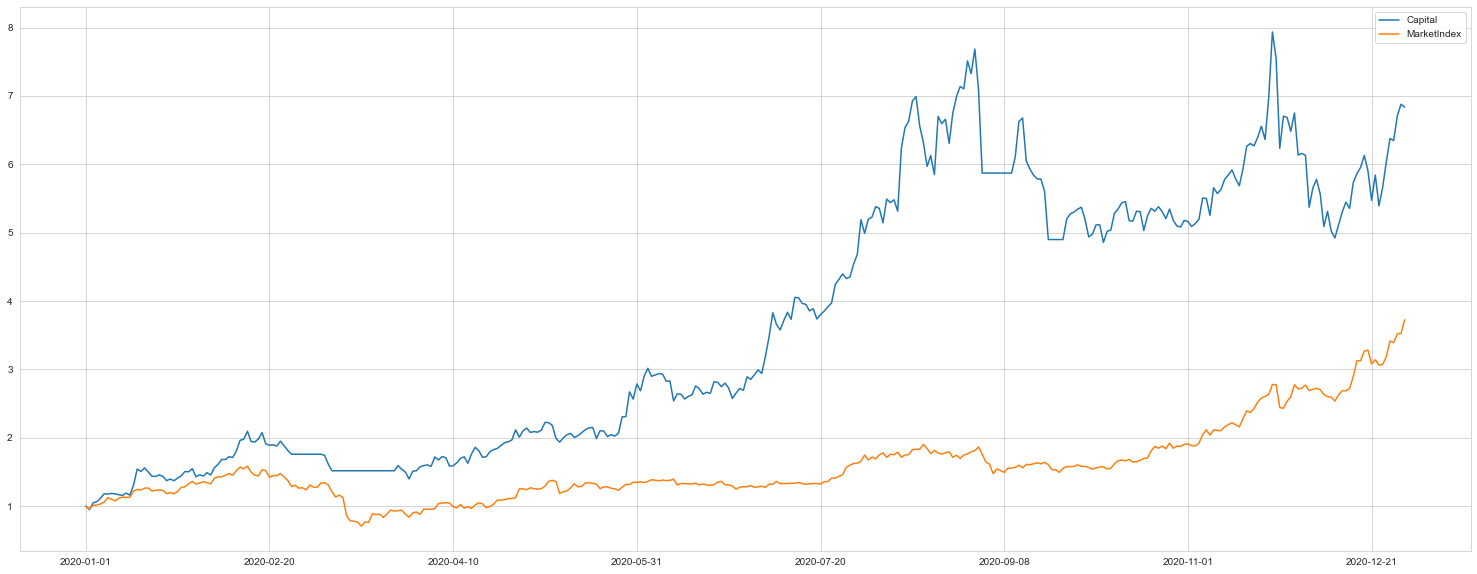

In [18]:
df_tmp = result[['Capital','MarketIndex']]
df_tmp['MarketIndex'] /= df_tmp['MarketIndex'][0]
df_tmp['Capital'] /= df_tmp['Capital'][0]
df_tmp.plot(figsize = (26,10))

<AxesSubplot:>

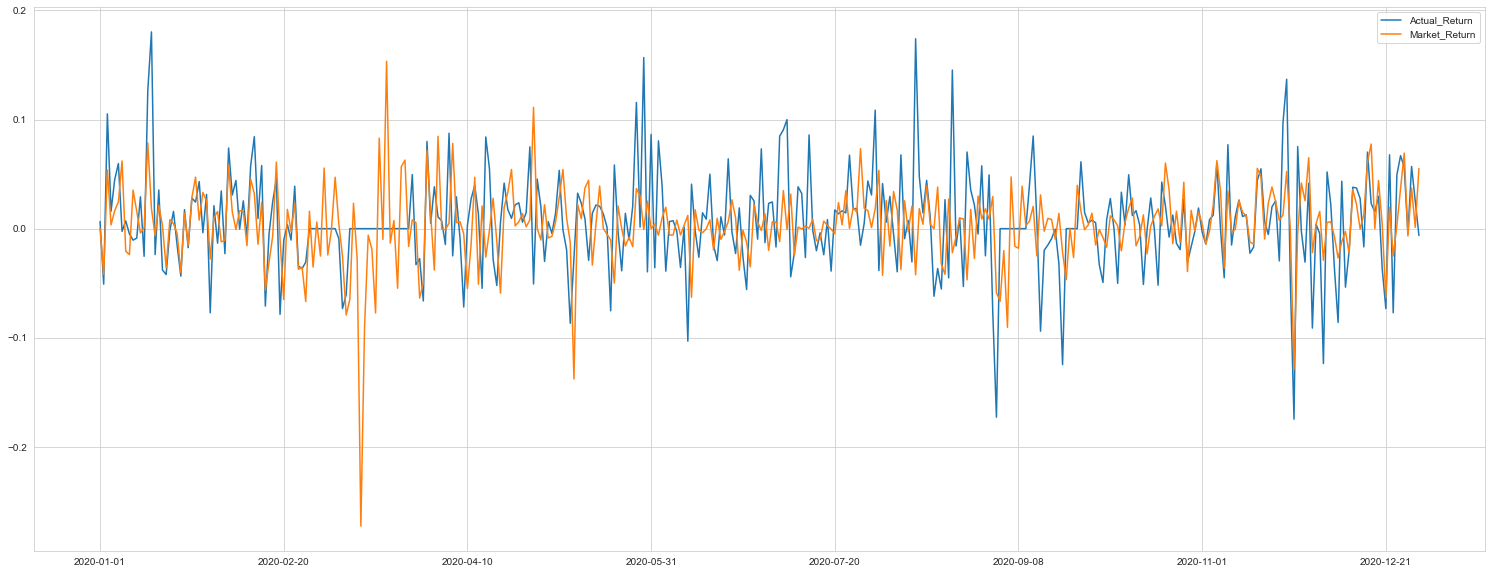

In [19]:
result[['Actual_Return','Market_Return']].plot(figsize = (26,10))

In [20]:
import empyrical 

def result_analysis(result):
    res = pd.DataFrame(columns=['Strategy', 'Market'], index=['Return','Max_drawdown','Annual_volatility','Sharpe_ratio','Calmar_ratio','Alpha','Beta','Tail_ratio'])
    res.loc['Return']['Strategy'] = f"{(result['Capital'][-1]/result['Capital'][0] - 1)*100:.2f}%"
    res.loc['Return']['Market'] = f"{(result['MarketIndex'][-1]/result['MarketIndex'][0] - 1)*100:.2f}%"
    
    res.loc['Max_drawdown']['Strategy'] = f"{empyrical.max_drawdown(result['Actual_Return'])*100:.2f}%"
    res.loc['Max_drawdown']['Market'] = f"{empyrical.max_drawdown(result['Market_Return'])*100:.2f}%"
    
    res.loc['Annual_volatility']['Strategy']  = empyrical.annual_volatility(result['Actual_Return'],period = 'daily')
    res.loc['Annual_volatility']['Market']  = empyrical.annual_volatility(result['Market_Return'],period = 'daily')
    
    res.loc['Sharpe_ratio']['Strategy']  = empyrical.sharpe_ratio(result['Actual_Return'],risk_free=0,period = 'daily')
    res.loc['Sharpe_ratio']['Market']  = empyrical.sharpe_ratio(result['Market_Return'],risk_free=0,period = 'daily')
    
    res.loc['Calmar_ratio']['Strategy']  = empyrical.calmar_ratio(result['Actual_Return'],period = 'daily')
    res.loc['Calmar_ratio']['Market']  = empyrical.calmar_ratio(result['Market_Return'],period = 'daily')
    
    res.loc['Alpha']['Strategy']  = empyrical.alpha_beta(result['Actual_Return'],result['Market_Return'],risk_free=0,period = 'daily')[0]
    res.loc['Alpha']['Market']  = empyrical.alpha_beta(result['Market_Return'],result['Market_Return'],risk_free=0,period = 'daily')[0]
    
    res.loc['Beta']['Strategy']  = empyrical.alpha_beta(result['Actual_Return'],result['Market_Return'],risk_free=0,period = 'daily')[1]
    res.loc['Beta']['Market']  = empyrical.alpha_beta(result['Market_Return'],result['Market_Return'],risk_free=0,period = 'daily')[1]
    
    res.loc['Tail_ratio']['Strategy']  = empyrical.tail_ratio(result['Actual_Return'])
    res.loc['Tail_ratio']['Market']  = empyrical.tail_ratio(result['Market_Return'])
    
    return res

result_analysis(result)

Strategy    Market
Return              583.63%   272.60%
Max_drawdown        -37.96%   -58.52%
Annual_volatility  0.720398  0.570234
Sharpe_ratio       2.236663   1.50295
Calmar_ratio       7.528396  1.690312
Alpha              2.861595       0.0
Beta               0.299381       1.0
Tail_ratio          1.26341  1.040407

# Strategy with long & short position
# Need to test the conditions of that we don't hold any CC

In [21]:
TEST_START = '2020-01-01'
TEMP_DATE = '2020-03-25'
CC_daily_data=pd.read_csv('CC_daily_data.csv').dropna()
capital = 1
performance = pd.DataFrame(columns = ['Date','Actual_Return','Capital','Allocation','Top10CC_real_return'])

for date in top10CC.loc[TEST_START:].index:
    if date not in data_BTC.index:
        continue
    
    # Initialize variables
    top10CC_predicted_return = pd.DataFrame(columns = ['Ticker','Predicted_Return'])
    top10CC_historical_return = pd.DataFrame()
    
    # Get expected(predicted) returns on the "date", and the previous real returns before the date
    for  CC_name in ast.literal_eval(top10CC.loc[date]['top10_Market']):
        exec(f"return_temp = data_{CC_name}.loc[date]['predictions']")
        top10CC_predicted_return = top10CC_predicted_return.append({'Ticker':CC_name,'Predicted_Return':return_temp},ignore_index = True)
        top10CC_historical_return = pd.concat([top10CC_historical_return,find_top10CC_historical_returns(CC_name,CC_daily_data)],axis = 1).dropna()
        
    top10CC_predicted_return = top10CC_predicted_return.set_index('Ticker')
    top10CC_real_return = top10CC_historical_return.loc[date].to_frame()
    top10CC_historical_return = top10CC_historical_return.loc[:date][:-1]
    
    return_sum = weights = 0
    top10CC_predicted_return_temp = top10CC_predicted_return[top10CC_predicted_return>0].dropna()
    if len(top10CC_predicted_return_temp) > 4:  
        # Get the optimal weight of top10CC on the "date"
        weights = find_optimal_weights_LS(top10CC_predicted_return['Predicted_Return'],top10CC_historical_return.cov())
        # Calcualte the real gain/loss on the "date"
        return_sum = (np.array(list(weights.values())).reshape(-1,1) * top10CC_real_return).sum()[0]
        
    capital *= (1+return_sum)
    performance = performance.append({'Date':date,'Actual_Return': return_sum,'Capital':capital,'Allocation':weights,"Top10CC_real_return":top10CC_real_return},ignore_index= True)
    print(f"Date: {date}   Return: {return_sum:4f}  Capital: {capital:4f}")
    
performance    

Date: 2020-01-01   Return: 0.046782  Capital: 1.046782
Date: 2020-01-02   Return: -0.058257  Capital: 0.985799
Date: 2020-01-03   Return: 0.108517  Capital: 1.092775
Date: 2020-01-04   Return: 0.018246  Capital: 1.112714
Date: 2020-01-05   Return: 0.078847  Capital: 1.200448
Date: 2020-01-06   Return: -0.024108  Capital: 1.171507
Date: 2020-01-07   Return: 0.025398  Capital: 1.201261
Date: 2020-01-08   Return: 0.023406  Capital: 1.229377
Date: 2020-01-09   Return: -0.017729  Capital: 1.207582
Date: 2020-01-10   Return: -0.032420  Capital: 1.168432
Date: 2020-01-11   Return: -0.019507  Capital: 1.145639
Date: 2020-01-12   Return: 0.050858  Capital: 1.203904
Date: 2020-01-13   Return: -0.027991  Capital: 1.170206
Date: 2020-01-14   Return: 0.128995  Capital: 1.321156
Date: 2020-01-15   Return: 0.305495  Capital: 1.724762
Date: 2020-01-16   Return: 0.006683  Capital: 1.736289
Date: 2020-01-17   Return: -0.038538  Capital: 1.669376
Date: 2020-01-18   Return: -0.003304  Capital: 1.663860
Da

Date: 2020-05-31   Return: 0.120666  Capital: 4.162726
Date: 2020-06-01   Return: -0.078501  Capital: 3.835946
Date: 2020-06-02   Return: 0.102823  Capital: 4.230370
Date: 2020-06-03   Return: 0.031636  Capital: 4.364202
Date: 2020-06-04   Return: -0.050320  Capital: 4.144597
Date: 2020-06-05   Return: 0.015623  Capital: 4.209349
Date: 2020-06-06   Return: 0.024392  Capital: 4.312024
Date: 2020-06-07   Return: -0.000798  Capital: 4.308581
Date: 2020-06-08   Return: -0.030856  Capital: 4.175636
Date: 2020-06-09   Return: -0.000758  Capital: 4.172469
Date: 2020-06-10   Return: -0.101460  Capital: 3.749129
Date: 2020-06-11   Return: 0.059931  Capital: 3.973818
Date: 2020-06-12   Return: 0.006890  Capital: 4.001199
Date: 2020-06-13   Return: -0.026680  Capital: 3.894449
Date: 2020-06-14   Return: 0.000115  Capital: 3.894897
Date: 2020-06-15   Return: 0.051936  Capital: 4.097183
Date: 2020-06-16   Return: 0.020468  Capital: 4.181046
Date: 2020-06-17   Return: 0.001313  Capital: 4.186536
Dat

Date: 2020-10-30   Return: 0.005672  Capital: 5.367313
Date: 2020-10-31   Return: 0.059675  Capital: 5.687610
Date: 2020-11-01   Return: 0.013153  Capital: 5.762418
Date: 2020-11-02   Return: -0.035283  Capital: 5.559103
Date: 2020-11-03   Return: 0.049886  Capital: 5.836425
Date: 2020-11-04   Return: 0.071192  Capital: 6.251932
Date: 2020-11-05   Return: 0.077540  Capital: 6.736705
Date: 2020-11-06   Return: 0.099622  Capital: 7.407830
Date: 2020-11-07   Return: -0.058730  Capital: 6.972771
Date: 2020-11-08   Return: 0.117643  Capital: 7.793068
Date: 2020-11-09   Return: 0.007192  Capital: 7.849120
Date: 2020-11-10   Return: 0.025175  Capital: 8.046718
Date: 2020-11-11   Return: 0.052925  Capital: 8.472593
Date: 2020-11-12   Return: 0.016692  Capital: 8.614021
Date: 2020-11-13   Return: 0.007873  Capital: 8.681841
Date: 2020-11-14   Return: -0.070037  Capital: 8.073790
Date: 2020-11-15   Return: -0.022467  Capital: 7.892398
Date: 2020-11-16   Return: 0.053974  Capital: 8.318382
Date: 

Date  Actual_Return    Capital  \
0    2020-01-01       0.046782   1.046782   
1    2020-01-02      -0.058257   0.985799   
2    2020-01-03       0.108517   1.092775   
3    2020-01-04       0.018246   1.112714   
4    2020-01-05       0.078847   1.200448   
..          ...            ...        ...   
355  2020-12-26       0.164397  11.573289   
356  2020-12-27       0.105423  12.793381   
357  2020-12-28       0.267418  16.214561   
358  2020-12-29       0.205244  19.542507   
359  2020-12-30       0.083552  21.175329   

                                            Allocation  \
0    {'BTC': 1.0, 'ETH': 0.72718, 'XRP': -0.95236, ...   
1    {'BTC': 1.0, 'ETH': 0.34058, 'XRP': -1.0, 'BCH...   
2    {'BTC': 1.0, 'ETH': 0.77021, 'XRP': -0.53287, ...   
3    {'BTC': 0.71548, 'ETH': -0.24408, 'XRP': -1.0,...   
4    {'BTC': 0.31112, 'ETH': 0.76072, 'XRP': -0.846...   
..                                                 ...   
355  {'BTC': 1.0, 'ETH': 0.02057, 'XRP': -1.0, 'LTC...   
356  {'BTC': 1.0, 'ETH': 0.34758, 'XRP': -1.0, 'LTC...   
357  {'BTC': 0.75137, 'ETH': 0.5307, 'XRP': -1.0, '...   
358  {'BTC': 1.0, 'ETH': 1.0, 'XRP': -1.0, 'LTC': 0...   
359  {'BTC': 0.68539, 'ETH': 0.77864, 'XRP': -1.0, ...   

                                   Top10CC_real_return  
0         2020-01-01
BTC    0.000914
ETH    0.00914...  
1         2020-01-02
BTC   -0.030273
ETH   -0.02627...  
2         2020-01-03
BTC    0.050172
ETH    0.05170...  
3         2020-01-04
BTC    0.008915
ETH    0.00666...  
4         2020-01-05
BTC    0.000089
ETH    0.00889...  
..                                                 ...  
355        2020-12-26
BTC     0.069389
ETH     0.01...  
356        2020-12-27
BTC    -0.006251
ETH     0.07...  
357        2020-12-28
BTC     0.030458
ETH     0.06...  
358        2020-12-29
BTC     0.010198
ETH     0.00...  
359        2020-12-30
BTC     0.052625
ETH     0.02...  

[360 rows x 5 columns]

In [22]:
result = pd.concat([performance.set_index('Date'), CC100_Index], axis = 1).dropna()
result

Actual_Return    Capital  \
2020-01-01       0.046782   1.046782   
2020-01-02      -0.058257   0.985799   
2020-01-03       0.108517   1.092775   
2020-01-04       0.018246   1.112714   
2020-01-05       0.078847   1.200448   
...                   ...        ...   
2020-12-26       0.164397  11.573289   
2020-12-27       0.105423  12.793381   
2020-12-28       0.267418  16.214561   
2020-12-29       0.205244  19.542507   
2020-12-30       0.083552  21.175329   

                                                   Allocation  \
2020-01-01  {'BTC': 1.0, 'ETH': 0.72718, 'XRP': -0.95236, ...   
2020-01-02  {'BTC': 1.0, 'ETH': 0.34058, 'XRP': -1.0, 'BCH...   
2020-01-03  {'BTC': 1.0, 'ETH': 0.77021, 'XRP': -0.53287, ...   
2020-01-04  {'BTC': 0.71548, 'ETH': -0.24408, 'XRP': -1.0,...   
2020-01-05  {'BTC': 0.31112, 'ETH': 0.76072, 'XRP': -0.846...   
...                                                       ...   
2020-12-26  {'BTC': 1.0, 'ETH': 0.02057, 'XRP': -1.0, 'LTC...   
2020-12-27  {'BTC': 1.0, 'ETH': 0.34758, 'XRP': -1.0, 'LTC...   
2020-12-28  {'BTC': 0.75137, 'ETH': 0.5307, 'XRP': -1.0, '...   
2020-12-29  {'BTC': 1.0, 'ETH': 1.0, 'XRP': -1.0, 'LTC': 0...   
2020-12-30  {'BTC': 0.68539, 'ETH': 0.77864, 'XRP': -1.0, ...   

                                          Top10CC_real_return  MarketIndex  \
2020-01-01       2020-01-01
BTC    0.000914
ETH    0.00914...      7068.77   
2020-01-02       2020-01-02
BTC   -0.030273
ETH   -0.02627...      6778.93   
2020-01-03       2020-01-03
BTC    0.050172
ETH    0.05170...      7152.82   
2020-01-04       2020-01-04
BTC    0.008915
ETH    0.00666...      7177.27   
2020-01-05       2020-01-05
BTC    0.000089
ETH    0.00889...      7296.59   
...                                                       ...          ...   
2020-12-26        2020-12-26
BTC     0.069389
ETH     0.01...     24145.53   
2020-12-27        2020-12-27
BTC    -0.006251
ETH     0.07...     23984.01   
2020-12-28        2020-12-28
BTC     0.030458
ETH     0.06...     24895.42   
2020-12-29        2020-12-29
BTC     0.010198
ETH     0.00...     24925.16   
2020-12-30        2020-12-30
BTC     0.052625
ETH     0.02...     26338.46   

            Market_Return  
2020-01-01       0.000000  
2020-01-02      -0.041867  
2020-01-03       0.053687  
2020-01-04       0.003412  
2020-01-05       0.016488  
...                   ...  
2020-12-26       0.069255  
2020-12-27      -0.006712  
2020-12-28       0.037296  
2020-12-29       0.001194  
2020-12-30       0.055152  

[360 rows x 6 columns]

<AxesSubplot:>

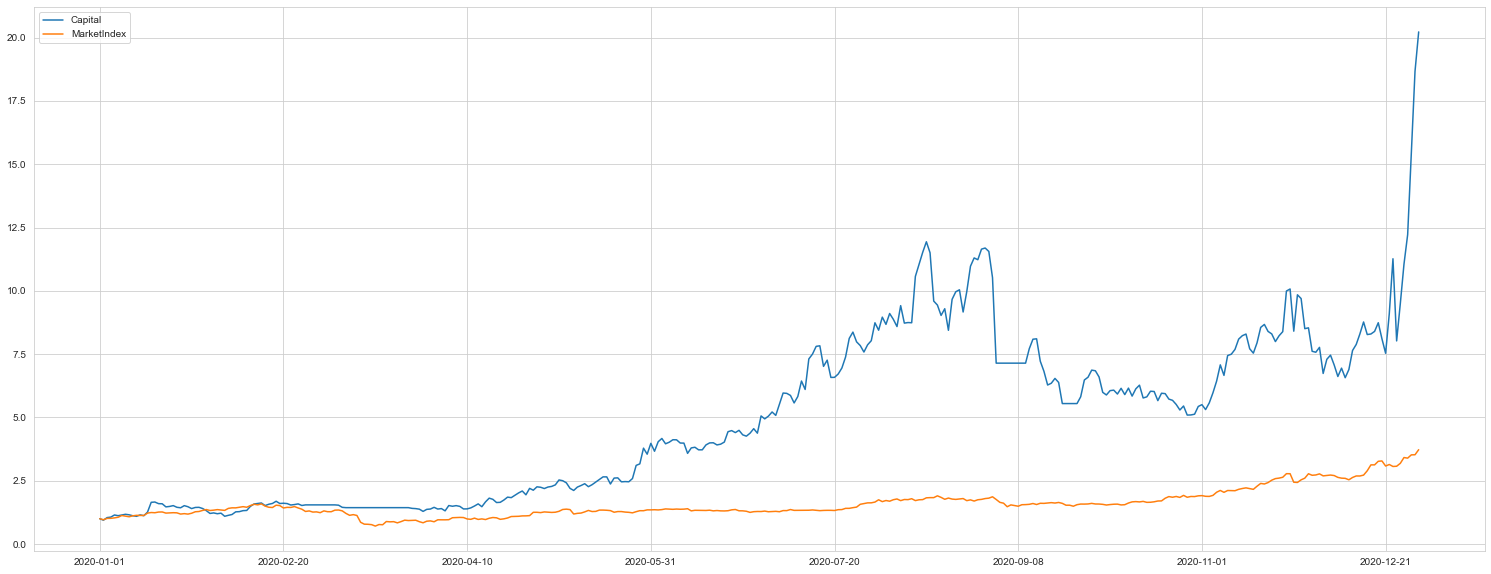

In [23]:
df_tmp = result[['Capital','MarketIndex']]
df_tmp['MarketIndex'] /= df_tmp['MarketIndex'][0]
df_tmp['Capital'] /= df_tmp['Capital'][0]
df_tmp.plot(figsize = (26,10))

<AxesSubplot:>

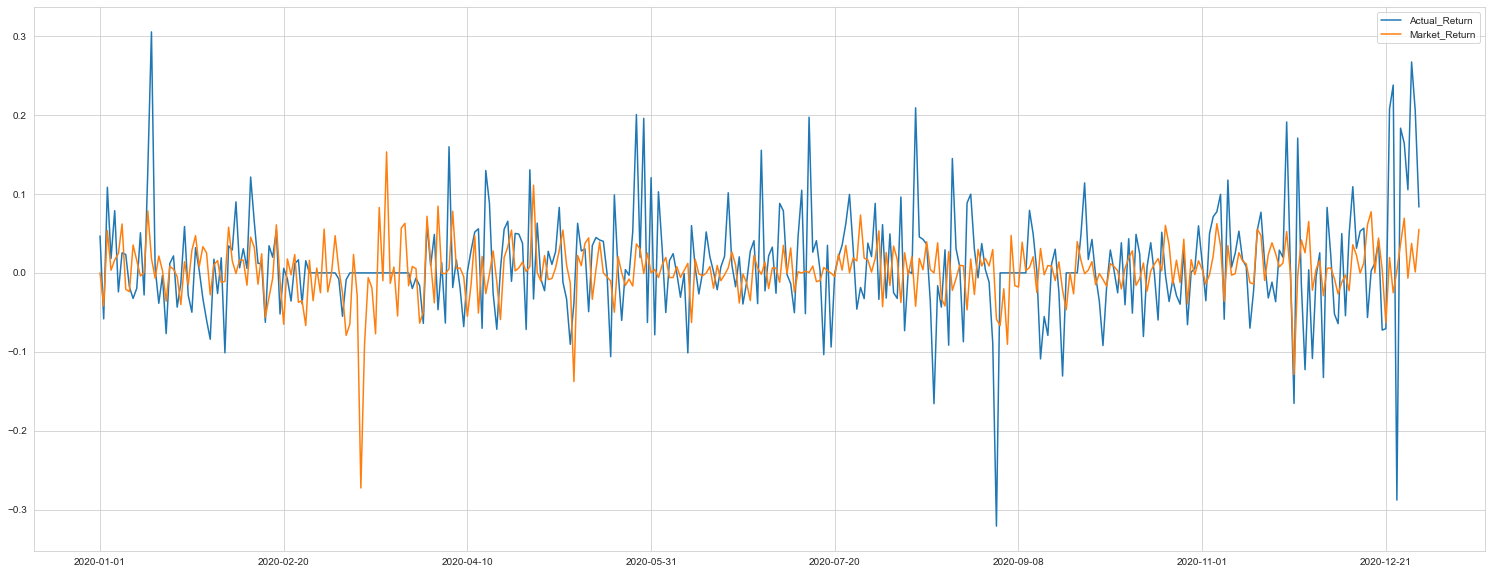

In [24]:
result[['Actual_Return','Market_Return']].plot(figsize = (26,10))

In [25]:
import empyrical 

def result_analysis(result):
    res = pd.DataFrame(columns=['Strategy', 'Market'], index=['Return','Max_drawdown','Annual_volatility','Sharpe_ratio','Calmar_ratio','Alpha','Beta','Tail_ratio'])
    res.loc['Return']['Strategy'] = f"{(result['Capital'][-1]/result['Capital'][0] - 1)*100:.2f}%"
    res.loc['Return']['Market'] = f"{(result['MarketIndex'][-1]/result['MarketIndex'][0] - 1)*100:.2f}%"
    
    res.loc['Max_drawdown']['Strategy'] = f"{empyrical.max_drawdown(result['Actual_Return'])*100:.2f}%"
    res.loc['Max_drawdown']['Market'] = f"{empyrical.max_drawdown(result['Market_Return'])*100:.2f}%"
    
    res.loc['Annual_volatility']['Strategy']  = empyrical.annual_volatility(result['Actual_Return'],period = 'daily')
    res.loc['Annual_volatility']['Market']  = empyrical.annual_volatility(result['Market_Return'],period = 'daily')
    
    res.loc['Sharpe_ratio']['Strategy']  = empyrical.sharpe_ratio(result['Actual_Return'],risk_free=0,period = 'daily')
    res.loc['Sharpe_ratio']['Market']  = empyrical.sharpe_ratio(result['Market_Return'],risk_free=0,period = 'daily')
    
    res.loc['Calmar_ratio']['Strategy']  = empyrical.calmar_ratio(result['Actual_Return'],period = 'daily')
    res.loc['Calmar_ratio']['Market']  = empyrical.calmar_ratio(result['Market_Return'],period = 'daily')
    
    res.loc['Alpha']['Strategy']  = empyrical.alpha_beta(result['Actual_Return'],result['Market_Return'],risk_free=0,period = 'daily')[0]
    res.loc['Alpha']['Market']  = empyrical.alpha_beta(result['Market_Return'],result['Market_Return'],risk_free=0,period = 'daily')[0]
    
    res.loc['Beta']['Strategy']  = empyrical.alpha_beta(result['Actual_Return'],result['Market_Return'],risk_free=0,period = 'daily')[1]
    res.loc['Beta']['Market']  = empyrical.alpha_beta(result['Market_Return'],result['Market_Return'],risk_free=0,period = 'daily')[1]
    
    res.loc['Tail_ratio']['Strategy']  = empyrical.tail_ratio(result['Actual_Return'])
    res.loc['Tail_ratio']['Market']  = empyrical.tail_ratio(result['Market_Return'])
    
    return res

result_analysis(result)

Strategy    Market
Return              1922.90%   272.60%
Max_drawdown         -57.34%   -58.52%
Annual_volatility   1.096141  0.570234
Sharpe_ratio             2.5   1.50295
Calmar_ratio       13.035001  1.690312
Alpha               11.18831       0.0
Beta                0.265368       1.0
Tail_ratio          1.475466  1.040407